## 인물사진 모드 만들기🤳💁‍♀️

___

💬 아이폰의 인물사진 모드(Portrait mode)로 촬영하면 인물을 제외한 배경은 흐리게 처리하여 피사체가 더 도드라지게 보입니다. 이번 프로젝트는 **딥러닝을 이용하여 인물사진 모드를 구현해보는 것**입니다.

💬 배경을 흐리게 하는 효과를 **shallow depth of field** 또는 **shallow focus**라고 합니다. 원래는 전문적인 카메라에서 생기는 현상이지만 최신 핸드폰은 2개의 렌즈를 통해 사진에 shallow focus **처리**를 합니다. 

💬 2개의 카메라로 이미지를 받아들이면 핸드폰은 **두 이미지를 비교하여 어떤 물체가 가까이 있고, 멀리 있는지를 파악해냅니다.** 이렇게 알아낸 거리정보를 기반으로 멀리 있는 물체를 흐리게 하는 것이 인물사진 모드의 원리입니다.

___

### 0. 어떻게 구현할까? 아웃라인 잡기


**이번 프로젝트에서는 하나의 렌즈로 촬영한 사진만으로 딥러닝을 이용하여 shallow focus 효과를 적용해볼 것입니다.**

과정은 다음과 같습니다.

📍 시맨틱 분할(Semantic segmentation)로 인물과 배경 분리하기

📍 배경 블러(blur)처리 하기

📍 두 이미지 합성하기

___

### 1. 사진 준비하기

In [2]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation

`urllib`: 웹에서 데이터를 다운로드 하는 패키지  
`cv2`: `OpenCV`로 이미지 처리하기 위한 라이브러리  
`pixellib`: 시맨틱 세그멘테이션을 편하게 사용할 수 있는 라이브러리  


cf) 모듈, 패키지, 라이브러리의 차이 https://www.bjcoding.com/343

(960, 1280, 3)


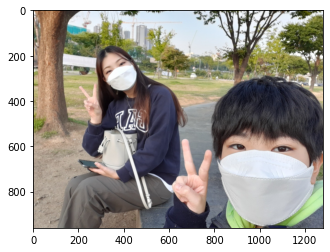

In [12]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.jpeg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

___

### 2. 세그멘테이션으로 사람 분리하기

#### 2.1. 세그멘테이션이란?

**`이미지 세그멘테이션(Image Segmentaion)`**: 이미지에서 픽셀 단위로 관심 객체를 추출하는 방법. 모든 픽셀에 라벨을 할당하고 같은 라벨은 공통적인 특징을 가진다고 가정.

![](https://i.imgur.com/Sp5l9P9.png)

**`시맨틱 세그멘테이션(Semantic Segmentation`**: 사람의 인식처럼 물리적 의미 단위로 인식하는 세그멘테이션. 이미지에서 픽셀을 사람, 자동차, 비행기 등의 물리적 단위로 **classification**하는 것.

![](https://media5.datahacker.rs/2021/11/image-16.png)

**`인스턴스 세그멘테이션(Instance Segmentation)`**: 하나의 클래스 내에서도 각각의 개체를 다르게 인식하는 것. 예를 들면 하나의 사진에서 사람1, 사람2, 사람3 등으로 분리하는 것.

![](https://miro.medium.com/max/591/1*Ox16veM29OVxGgIPrVmMhQ.png)
![](https://miro.medium.com/max/875/1*jHv5C23SLtL3UFeR8VnohQ.png)

___

#### 2.2. `DeepLab` 모델 이용하여 시맨틱 세그멘테이션 해보기

세그멘테이션 모델에는 다양한 종류가 있습니다. (`DeepLab`, `FCN`, `SegNet`, `U-Net` 등) 그 중 성능이 좋은 `DeepLab v3+`을 사용할 것입니다. 다음은 `DeepLab`의 구조 특징에 관한 설명입니다.

* **`Atrous Convolution`**

> *a trous: (french) '구멍이 있는'*

일반적인 Convolution (2D convolution using a kernel size of 3, stride of 1 and padding) 👇

![](https://blog.kakaocdn.net/dn/L4OGj/btq25ZYvmXA/X3wI5PCqZ8yAgkoKnGcopk/img.gif)


atrous convolution (2D convolution using a 3 kernel with a dilation rate of 2 and no padding) 👇

![](https://blog.kakaocdn.net/dn/dXRWM7/btq250wkFQj/OKY0Jy2k7TNE7zPvtpivh0/img.gif)

일반적인 convolution과 달리 atrous convolution은 필터의 내부에 빈 공간을 둔 채로 작동합니다. 얼마나 빈 공간을 둘 지는 파라미터 r(rate)로 결정합니다. r=1인 경우 기존 convolution과 동일하고, r이 커질수록, 빈 공간이 넓어지게 됩니다. 

**필터에 빈 공간을 두면 동일한 조건일 때, 기존 convolution에 비해 더 넓은 field of view를 가질 수 있습니다.** 위의 그림을 보면, 기존 convolution의 경우 3x3 필터는 3x3의 시야(field of view)를 갖고 5x5 크기의 output을 출력합니다. 반면 아래 그림의 atrous convolution의 경우, 같은 3x3 필터로 5x5의 시야(field of view)를 갖고 3x3 크기의 output을 출력합니다.

보통 semantic segmentation에서 높은 성능을 내기 위해서는 한 픽셀이 커버하는 영역이 크면 클수록 좋습니다. 따라서 atrous convolution을 이용하면 파라미터 수를 늘리지 않고도 segmentation을 잘 수행할 수 있게됩니다.

___

* **`Depthwise separable convolution`**

일반적인 convolution 👇


![](https://bloglunit.files.wordpress.com/2018/07/conv.png)

Depthwise separable convolution 👇

![](https://bloglunit.files.wordpress.com/2018/07/depthwise_separable_conv.png?w=300&h=435)

Depthwise separable convolution은 일반적인 convolution에서 진행되는 연산을 여러 단계로 나누어서 따로따로 계산하는 방법입니다. 따라서 결과값은 같지만 과정은 조금 더 복잡해집니다.

그런데도 Depthwise separable convolution을 사용하는 이유는, 기존 모델과 유사한 성능을 보이면서도 사용되는 파라미터 수와 연산량을 획기적으로 줄일 수 있기 때문입니다.

___

`PixelLib`이 제공하는 모델을 불러옵니다.

In [4]:
# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f7fd3d8e400>)

다운로드한 모델을 이용해 원하는 `semantic_segmentation()` 모델을 생성합니다. **(PASCAL VOC 데이터셋으로 학습된 모델 http://host.robots.ox.ac.uk/pascal/VOC/)**

In [5]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

모델에 이미지를 입력합니다.

In [13]:
segvalues, output = model.segmentAsPascalvoc(img_path)

PASCAL VOC 데이터셋의 라벨 종류는 아래와 같이 20개 입니다.(background 제외)

In [7]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

이 중 사람(`person`) 라벨을 가진 영역만 검출해내야 합니다.

모델 출력값을 살펴봅니다.

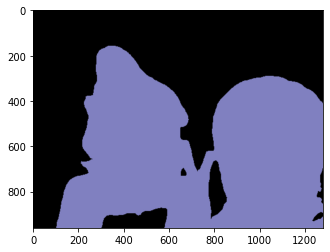

In [17]:
plt.imshow(output)
plt.show()

`output`에는 세그멘테이션 된 결과가 각각 다른 색상으로 담겨 있습니다.

In [15]:
segvalues

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]])}

`segvalues`에는 라벨 인덱스들이 담겨있는 `class_ids`와 `masks`가 들어있습니다. 지금 사진은 사람과 배경만 인식되기 때문에 `class_ids`에 0과 15만 들어있습니다.

In [16]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


`class_ids`를 통해 어떤 라벨들이 인식되었는지 확인해볼 수 있습니다.

___

물체마다 `output`에 어떤 색상으로 나타나 있는지 알아봅니다.

In [18]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

사람의 색상은 인덱스값 15를 통해 알 수 있습니다. (다른 라벨은 `colormap[class_id]`로 찾을 수 있음)

In [19]:
colormap[15]

array([192, 128, 128])